# **Installing And Importing Required Libraries**

In [ ]:
!pip install tensorflow pandas matplotlib seaborn scikit-learn
import tensorflow as tf
import pickle
import json

# **Loading the Dataset**

In [ ]:
import pandas as pd
df = pd.read_csv("/content/Book_Genre.csv")
df.head()

,Unnamed: 0,Title,Author,Main Genre,Sub Genre,Type,Price,Rating,No. of People rated,URLs
0,0,The Complete Novel of Sherlock Holmes,Arthur Conan Doyle,"Arts, Film & Photography",Cinema & Broadcast,Paperback,₹169.00,4.4,19923.0,https://www.amazon.in/Complete-Novels-Sherlock...
1,1,Black Holes (L) : The Reith Lectures [Paperbac...,Stephen Hawking,"Arts, Film & Photography",Cinema & Broadcast,Paperback,₹99.00,4.5,7686.0,https://www.amazon.in/Black-Holes-Lectures-Ste...
2,2,The Kite Runner,Khaled Hosseini,"Arts, Film & Photography",Cinema & Broadcast,Kindle Edition,₹175.75,4.6,50016.0,https://www.amazon.in/Kite-Runner-Khaled-Hosse...
3,3,Greenlights: Raucous stories and outlaw wisdom...,Matthew McConaughey,"Arts, Film & Photography",Cinema & Broadcast,Paperback,₹389.00,4.6,32040.0,https://www.amazon.in/Greenlights-Raucous-stor...
4,4,The Science of Storytelling: Why Stories Make ...,Will Storr,"Arts, Film & Photography",Cinema & Broadcast,Paperback,₹348.16,4.5,1707.0,https://www.amazon.in/Science-Storytelling-Wil...


# **Filtering Genres with ≥ 100 Samples**

In [ ]:
genre_counts = df['Main Genre'].value_counts()
valid_genres = genre_counts[genre_counts >= 100].index.tolist()
df = df[df['Main Genre'].isin(valid_genres)]

print(f"Genres used: {len(valid_genres)}")
df['Main Genre'].value_counts()

Genres used: 24


,count
Main Genre,
Children's Books,1450
Romance,1124
Sports,854
Literature & Fiction,400
Teen & Young Adult,350
"Computing, Internet & Digital Media",350
"Crafts, Home & Lifestyle",300
Religion,300
Medicine & Health Sciences,250


# **Label Encode & Prepare Data**

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Main Genre'])

X = df['Title'].astype(str)
y = df['label']

# **Tokenize and Pad Sequences**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)

sequences = tokenizer.texts_to_sequences(X)
padded_sequences = pad_sequences(sequences, maxlen=15, padding='post')

# **Train/Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

# **Build and Train LSTM Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=15),
    LSTM(64),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.1719 - loss: 2.9293 - val_accuracy: 0.2431 - val_loss: 2.4585
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2723 - loss: 2.2865 - val_accuracy: 0.3814 - val_loss: 2.1166
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4442 - loss: 1.8299 - val_accuracy: 0.4358 - val_loss: 2.0260
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5110 - loss: 1.5711 - val_accuracy: 0.4522 - val_loss: 2.0485
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5622 - loss: 1.3647 - val_accuracy: 0.4620 - val_loss: 2.1163


# **Evaluate and Visualize**

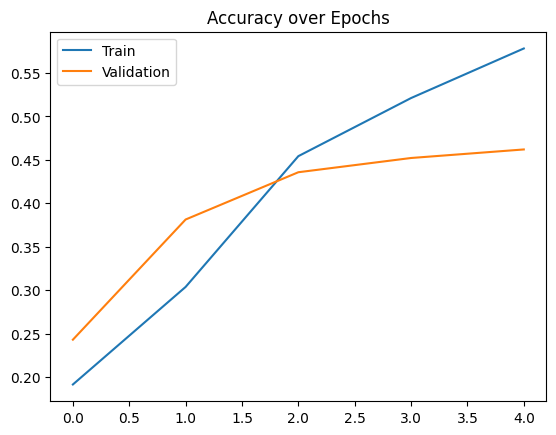

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

# **Save Model and Tokenizer**

In [ ]:
# Loading model
model.save("genre_model.h5")
model = tf.keras.models.load_model("genre_model.h5")
model.save("genre_model_legacy.h5", save_format="h5")
model.export("genre_model_tf")
!zip -r genre_model_tf.zip genre_model_tf


# ✅ Saving tokenizer as json
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
tokenizer_config = tokenizer.to_json()  # convert to json
with open("tokenizer_config.json", "w") as f:
    f.write(tokenizer_config)

# ✅ Save label map
# Convert class indices to genre names
label_map = dict(enumerate(label_encoder.classes_))
with open("label_map.json", "w") as f:
    json.dump(label_map, f)

print("✅ Model, tokenizer, and label map saved.")

Saved artifact at 'genre_model_tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 15), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 24), dtype=tf.float32, name=None)
Captures:
  140229867629712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140229867624720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140229867626640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140229867629136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140229867626256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140229867623760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140229867628752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140229867627984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  adding: genre_model_tf/ (stored 0%)
  adding: genre_model_tf/saved_model.pb (deflated 85%)
  adding: genre_model_tf/fingerprint.pb (stored 0%)
  adding: genre_mode